Importamos las librerías necesarias

In [96]:
import matplotlib.pyplot as plt
import cornac
import pandas as pd
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, Precision, MAE, RMSE
from cornac.models import ItemKNN, BPR, MF
from sklearn.metrics.pairwise import cosine_similarity

Cargar el dataset de MovieLens 100K

In [97]:
file_path = 'datasets/ml-100k/u.data'
dataframe = pd.read_csv(file_path, sep='|', header=None, encoding='latin-1')
dataset = cornac.datasets.movielens.load_feedback(fmt='UIRT')

file_path = 'datasets/ml-100k/u.item'
movies = pd.read_csv(file_path, sep='|', header=None, encoding='latin-1')

movies.columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movie_genres = movies[genre_columns]
movie_similarities = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {movie_similarities.shape}")

Dimensions of our genres cosine similarity matrix: (1682, 1682)


Exploración de datos

In [98]:
file_path = 'datasets/ml-100k/u.info'
info = pd.read_csv(file_path, sep=' ', header=None, encoding='latin-1')
info.columns = ['data', 'info']
print(info)

     data     info
0     943    users
1    1682    items
2  100000  ratings


In [99]:
sparsity = info['data'][2]/(info['data'][0]*info['data'][1])
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 6.3%


In [100]:
# Diccionario con las similitudes entre peliculas ordenadas ascendentemente
sim_movies = {}
for idx in range(len(movie_similarities)):
    sim_scores = list(enumerate(movie_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1])
    sim_movies[idx] = sim_scores

Crear modelos propios

In [101]:
class Hybrid(cornac.models.Recommender):
    def __init__(self, models, weights, name="Hybrid"):
        super().__init__(name=name)
        self.models = models
        self.weights = weights

    def fit(self, train_set, eval_set=None):
        super().fit(train_set,eval_set)
        for m in self.models:
            m.fit(train_set, eval_set)

    def score(self, user_idx, item_idx=None):
        ponderated_sum = 0
        # if each weight is 1/len(weights)then the score is the average  
        for idx in range(len(self.models)):
            ponderated_sum += self.models[idx].score(user_idx, item_idx)*self.weights[idx]

        return ponderated_sum/sum(self.weights)

class DHybrid(Hybrid):
    def __init__(self, models, weights, name="Hybrid", flag=False):
        super().__init__(models, weights, name)
        self.flag = flag
        
    def fit(self, train_set, eval_set=None):
        super().fit(train_set, eval_set)
        
    def score(self, user_idx, item_idx=None):
        return super().score(user_idx, item_idx)
    
    def recommend(self, user_id, k=-1, remove_seen=False, train_set=None, n=3):
        recommendations = super().recommend(user_id, k, remove_seen, train_set)
        if self.flag:
            for idx in range(n):
                recommendations[-idx-1] = sim_movies[int(recommendations[idx])][0][0]
            # sim_scores = sim_movies[int(recommendations[0])]
            # similar_movies = [i[0] for i in sim_scores[:n]]
            # return recommendations + similar_movies
        return recommendations
    
    def novelty(self, user_id, k, item_popularity):
        recommendations = self.recommend(user_id, k)
        return novelty(recommendations, item_popularity)

    

Definir el método de evaluación

In [102]:
ratio_split = RatioSplit(data=dataset, test_size=0.2, rating_threshold=4.0, exclude_unknowns=True, verbose=True)

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1652
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1652
Number of ratings = 19965
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1652


Definir los modelos a emplear

In [103]:
mf = MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
svd = cornac.models.SVD()
knn = ItemKNN(k=20, similarity='cosine', name='ItemKNN')
bpr = cornac.models.BPR(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
hybrid = DHybrid([svd, bpr, knn], (4, 1, 6), flag=True)

models = [mf, bpr, svd, knn, hybrid]

Definir las metricas a utilizar

In [104]:
metrics = [MAE(), RMSE(), Recall(10), Precision(10)]

Definir el experimento


In [105]:
experiment = cornac.Experiment(eval_method=ratio_split, models=models, metrics=metrics)

Ejecutar el experimento

In [106]:
experiment.run()


[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/19965 [00:00<?, ?it/s]

Ranking:   0%|          | 0/943 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Rating:   0%|          | 0/19965 [00:00<?, ?it/s]

Ranking:   0%|          | 0/943 [00:00<?, ?it/s]


[SVD] Training started!

[SVD] Evaluation started!


Rating:   0%|          | 0/19965 [00:00<?, ?it/s]

Ranking:   0%|          | 0/943 [00:00<?, ?it/s]


[ItemKNN] Training started!


  0%|          | 0/1652 [00:00<?, ?it/s]


[ItemKNN] Evaluation started!


Rating:   0%|          | 0/19965 [00:00<?, ?it/s]

Ranking:   0%|          | 0/943 [00:00<?, ?it/s]


[Hybrid] Training started!


/usr/local/lib/python3.12/dist-packages/cornac/models/recommender.py:322: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/1652 [00:00<?, ?it/s]


[Hybrid] Evaluation started!


Rating:   0%|          | 0/19965 [00:00<?, ?it/s]

Ranking:   0%|          | 0/943 [00:00<?, ?it/s]


TEST:
...
        |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) | Test (s)
------- + ------ + ------ + ------------ + --------- + --------- + --------
MF      | 0.7435 | 0.9023 |       0.0672 |    0.0464 |    0.5940 |   9.0633
BPR     | 2.1572 | 2.3603 |       0.1138 |    0.1120 |    0.4082 |   5.6723
SVD     | 0.7494 | 0.9084 |       0.0574 |    0.0397 |    0.3600 |   7.6911
ItemKNN | 0.8222 | 0.9944 |       0.0305 |    0.0176 |    0.4566 |  26.0046
Hybrid  | 0.7968 | 0.9476 |       0.1356 |    0.1042 |    1.8670 |  39.0407



Extraer los resultados de las métricas

In [107]:
results = experiment.result
mean_mae = results[0].metric_avg_results['MAE']
mean_rmse = results[0].metric_avg_results['RMSE']
mean_precision = results[0].metric_avg_results['Precision@10']
mf_mae = results[1].metric_avg_results['MAE']
mf_rmse = results[1].metric_avg_results['RMSE']
mf_precision = results[1].metric_avg_results['Precision@10']
bpr_mae = results[2].metric_avg_results['MAE']
bpr_rmse = results[2].metric_avg_results['RMSE']
bpr_precision = results[2].metric_avg_results['Precision@10']
svd_mae = results[3].metric_avg_results['MAE']
svd_rmse = results[3].metric_avg_results['RMSE']
svd_precision = results[3].metric_avg_results['Precision@10']
knn_mae = results[4].metric_avg_results['MAE']
knn_rmse = results[4].metric_avg_results['RMSE']
knn_precision = results[4].metric_avg_results['Precision@10']

Crear un gráfico de barras para mostrar los resultados

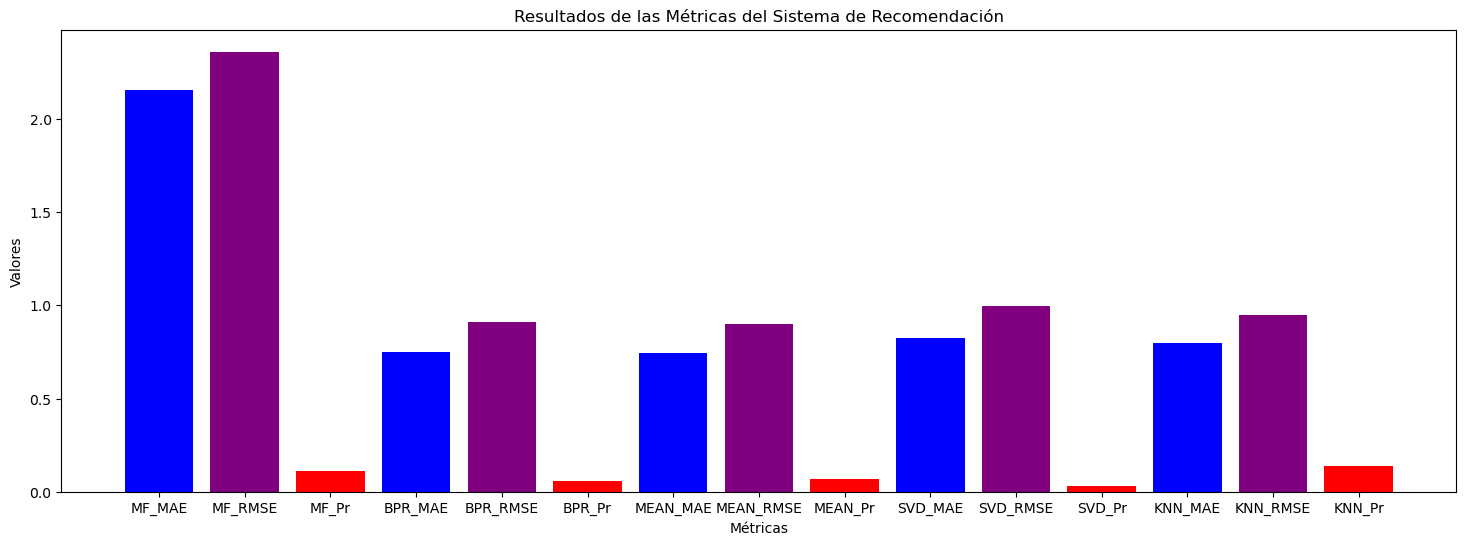

In [108]:
metrics_names = ['MF_MAE', 'MF_RMSE', 'MF_Pr', 'BPR_MAE', 'BPR_RMSE', 'BPR_Pr', 'MEAN_MAE', 'MEAN_RMSE', 'MEAN_Pr', 'SVD_MAE', 'SVD_RMSE', 'SVD_Pr', 'KNN_MAE', 'KNN_RMSE', 'KNN_Pr']
values = [mf_mae, mf_rmse, mf_precision, bpr_mae, bpr_rmse, bpr_precision, mean_mae, mean_rmse, mean_precision, svd_mae, svd_rmse, svd_precision, knn_mae, knn_rmse, knn_precision] 

plt.figure(figsize=(18, 6))
plt.bar(metrics_names, values, color=['blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Resultados de las Métricas del Sistema de Recomendación')
plt.show()


### Diversity Metrics ###

In [109]:
def calculate_item_popularity(dataset):
    """
    Calculate the popularity of each item in the dataset.

    Parameters:
    dataset (list of tuples): List of user-item interactions, where each tuple is (user_id, item_id, rating).

    Returns:
    dict: Dictionary with item indices as keys and their popularity (number of interactions) as values.
    """
    item_popularity = {}
    for interaction in dataset:
        item_id = interaction[1]
        if item_id in item_popularity:
            item_popularity[item_id] += 1
        else:
            item_popularity[item_id] = 1
    return item_popularity

Novelty for models

In [110]:
def novelty(recommendation_list, item_popularity):
    """
    Calculate the novelty of a recommendation list.

    Parameters:
    recommendation_list (list): List of recommended item indices.
    item_popularity (dict): Dictionary with item indices as keys and their popularity as values.

    Returns:
    float: Novelty score.
    """
    total_novelty = 0.0
    for item in recommendation_list:
        total_novelty += 1 / (1 + item_popularity.get(item, 0))

    return total_novelty / len(recommendation_list)

Calculating novelty for each model

In [111]:
item_popularity = calculate_item_popularity(dataset)

for model in models:
    novelty_score = 0
    for user_id in range(1, model.total_users):
        
        recs = model.recommend(user_id=str(user_id), k=10)
        
        if model.name == 'Hybrid':
            novelty_score += model.novelty(str(user_id), 10, item_popularity)
        else:
            novelty_score += novelty(recs, item_popularity)
    avg = novelty_score / info['data'][0]
    print(f"Novelty score average of model {model.name}: {avg}")

Novelty score average of model MF: 0.020517695877850198
Novelty score average of model BPR: 0.0025440517644653004
Novelty score average of model SVD: 0.027065020853787713
Novelty score average of model ItemKNN: 0.2696052799346532
Novelty score average of model Hybrid: 0.32068510723202376
